# Imports

In [125]:
import os # to access the file names of the images
import cv2     # for readcapturing images
import math   # for mathematical operations
import pickle
import numpy as np    # for mathematical operations
import pandas as pd #
import tensorflow as tf #machine learning libraries 
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
from skimage.transform import resize   # for resizing images

from tqdm.notebook import tqdm # to show progress in an user friendly manner

In [126]:

import math   # for mathematical operations
from skimage.transform                   import resize   # for resizing images
from tensorflow.keras.models             import Sequential
from tensorflow.keras.preprocessing      import image   # for preprocessing the images
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers             import Dense, InputLayer, Dropout, MaxPooling2D
from tensorflow.keras.utils              import to_categorical
from tensorflow.keras.layers import Dense,GRU,LSTM,Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,Conv2D,GlobalMaxPooling1D,MaxPooling1D,MaxPool2D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import cv2     # for capturing images


reloadStorage = True # if false then doesn't look at new data and only trains using existing data

In [127]:

def load_files(directory, unprocessed_files):
    if len(unprocessed_files) <= 1:
            return;
    processed_files = pickle.load(open('../train/vgg/'+directory+'/processed_files.pickle',"rb"))
    image_array = []
    for img_name in tqdm(unprocessed_files):
        img = cv2.imread("../train/image/"+directory+"/"+img_name)
        if type(img) == type(None):
            print("---------------------------------------------------------",img_name)
            img = np.zeros([224,224,3])
        res_img = resize(img, preserve_range=True, output_shape=(224,224)).astype(int)
        image_array.append(res_img)
    image_nparray = np.array(image_array) # with dimension changed
    del image_array
    print("Converted into np array")
    image_nparray = preprocess_input(image_nparray) # preprocessed
    print("Preprocessing completed")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_nparray = base_model.predict(image_nparray)
    print("Base model imposed")
    
    preprocessed_files = pickle.load(open('../train/vgg/'+directory+'/preprocessed.pickle',"rb"))
    if preprocessed_files.shape[0] == 0:
        preprocessed_files = image_nparray
    else:
        preprocessed_files = np.concatenate((preprocessed_files,image_nparray),axis=0)
    pickle.dump(preprocessed_files,open('../train/vgg/'+directory+'/preprocessed.pickle',"wb"))
    processed_files += unprocessed_files
    pickle.dump(processed_files,open('../train/vgg/'+directory+'/processed_files.pickle',"wb"))
    print("All done")

if(reloadStorage):
    for dirs in os.listdir("../train/image"):
        processed_files = pickle.load(open('../train/vgg/'+dirs+'/processed_files.pickle',"rb"))
        image_list = os.listdir("../train/image/"+dirs)
        unprocessed_files = [img for img in image_list if img not in processed_files]
        print(len(unprocessed_files), dirs,"unprocessed files found")
        
        process_batch_size = 1024
        batch = []
        for i in range(len(unprocessed_files)):
            batch.append(unprocessed_files[i])
            if i%process_batch_size == 0 or i == len(unprocessed_files)-1:
                load_files(dirs,batch)
                batch = []


1 circular unprocessed files found
48 other unprocessed files found


  0%|          | 0/47 [00:00<?, ?it/s]

Converted into np array
Preprocessing completed
Base model imposed
All done
1 rod unprocessed files found


# Train Files Generation

In [128]:
if(reloadStorage):
    circular_preprocessed = pickle.load(open('../train/vgg/circular/preprocessed.pickle',"rb"))
    rod_preprocessed = pickle.load(open('../train/vgg/rod/preprocessed.pickle',"rb"))
    other_preprocessed = pickle.load(open('../train/vgg/other/preprocessed.pickle',"rb"))
    circular_y = np.zeros((circular_preprocessed.shape[0],1))
    rod_y = np.ones((rod_preprocessed.shape[0],1))
    other_y = np.ones((other_preprocessed.shape[0],1)) * 2
    
    print("preprocessed files loaded")
    
    X = np.concatenate((circular_preprocessed,rod_preprocessed,other_preprocessed),axis=0)
    Y = np.concatenate((circular_y,rod_y,other_y),axis=0)
    
    del circular_preprocessed
    del rod_preprocessed
    del other_preprocessed
    
    p = np.random.permutation(Y.shape[0])
    X = X[p]
    Y = Y[p]
    
    print("X and Y created")
    
    train_frac = 0.9
    test_frac  = 0.1
    train_loc = int(train_frac*Y.shape[0])
    X_train = X[:train_loc]
    X_test = X[train_loc:]

    Y_train = to_categorical(Y[:train_loc],num_classes=3)
    Y_test = to_categorical(Y[train_loc:],num_classes=3)
#     Y_train = Y[:train_loc]
#     Y_test = Y[train_loc:]
    
    print("Permutation generated")
    
    pickle.dump(X_train,open('../train/X_train.pickle',"wb"))
    pickle.dump(X_test,open('../train/X_test.pickle',"wb"))
    pickle.dump(Y_train,open('../train/Y_train.pickle',"wb"))
    pickle.dump(Y_test,open('../train/Y_test.pickle',"wb"))
    print("All Done")
else:
    X_train = pickle.load(open('../train/X_train.pickle',"rb"))
    X_test = pickle.load(open('../train/X_test.pickle',"rb"))
    Y_train = pickle.load(open('../train/Y_train.pickle',"rb"))
    Y_test = pickle.load(open('../train/Y_test.pickle',"rb"))

preprocessed files loaded
X and Y created
Permutation generated
All Done


In [129]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(513, 7, 7, 512)
(58, 7, 7, 512)
(513, 3)
(58, 3)


# Model Segment

In [130]:
model = Sequential()
model.add(Conv2D(32,(5,5),padding='same',activation='relu',input_shape=(7,7,512)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(units=90, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='sigmoid'))    # output layer
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 7, 7, 32)          409632    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 90)                26010     
_________________________________________________________________
dropout_27 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)               

C:\Users\Sanidhya\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [131]:
%%time

batch_size = 1024
epoch = 75

history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=epoch, batch_size=batch_size, verbose=1)


Epoch 1/75
1/1 [==============================] - 2s 2s/step - loss: 0.6913 - accuracy: 0.3684 - val_loss: 0.5851 - val_accuracy: 0.7069
Epoch 2/75
1/1 [==============================] - 1s 855ms/step - loss: 0.6714 - accuracy: 0.4308 - val_loss: 0.5618 - val_accuracy: 0.8103
Epoch 3/75
1/1 [==============================] - 1s 810ms/step - loss: 0.6577 - accuracy: 0.4172 - val_loss: 0.5427 - val_accuracy: 0.8103
Epoch 4/75
1/1 [==============================] - 1s 830ms/step - loss: 0.6452 - accuracy: 0.4464 - val_loss: 0.5276 - val_accuracy: 0.8103
Epoch 5/75
1/1 [==============================] - 1s 845ms/step - loss: 0.6253 - accuracy: 0.5224 - val_loss: 0.5150 - val_accuracy: 0.8103
Epoch 6/75
1/1 [==============================] - 1s 838ms/step - loss: 0.5995 - accuracy: 0.5127 - val_loss: 0.5042 - val_accuracy: 0.8103
Epoch 7/75
1/1 [==============================] - 1s 825ms/step - loss: 0.6060 - accuracy: 0.5439 - val_loss: 0.4942 - val_accuracy: 0.8103
Epoch 8/75
1/1 [=======

1/1 [==============================] - 1s 670ms/step - loss: 0.3544 - accuracy: 0.8947 - val_loss: 0.2569 - val_accuracy: 0.9483
Epoch 60/75
1/1 [==============================] - 1s 638ms/step - loss: 0.3623 - accuracy: 0.8694 - val_loss: 0.2560 - val_accuracy: 0.9483
Epoch 61/75
1/1 [==============================] - 1s 650ms/step - loss: 0.3594 - accuracy: 0.8596 - val_loss: 0.2552 - val_accuracy: 0.9483
Epoch 62/75
1/1 [==============================] - 1s 680ms/step - loss: 0.3550 - accuracy: 0.8791 - val_loss: 0.2543 - val_accuracy: 0.9483
Epoch 63/75
1/1 [==============================] - 1s 676ms/step - loss: 0.3583 - accuracy: 0.8791 - val_loss: 0.2535 - val_accuracy: 0.9483
Epoch 64/75
1/1 [==============================] - 1s 744ms/step - loss: 0.3504 - accuracy: 0.8928 - val_loss: 0.2526 - val_accuracy: 0.9483
Epoch 65/75
1/1 [==============================] - 1s 665ms/step - loss: 0.3556 - accuracy: 0.8869 - val_loss: 0.2517 - val_accuracy: 0.9483
Epoch 66/75
1/1 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


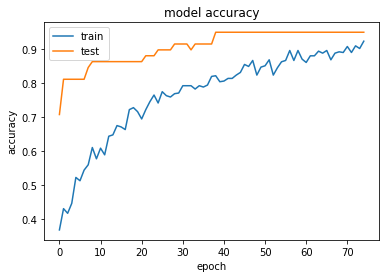

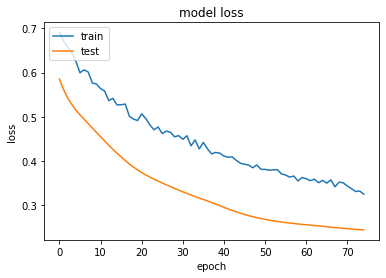

In [132]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [133]:
###### Confusion Matrix ##########
# cm = confusion_matrix(np.argmax(model.predict(X_test),axis=1) , np.argmax(Y_test,axis=1))
# sum = np.sum(cm)
# accuracy = (cm[0][0] + cm[1][1])/sum
# print('-------------Confusion Matrix-----------\n', cm,'\n----------------------------------------')
# print('Test accuracy   ',accuracy)

cm = confusion_matrix(np.argmax(model.predict(X_test),axis=1) , np.argmax(Y_test,axis=1))
sum = np.sum(cm)
accuracy = (cm[0][0] + cm[1][1]+ cm[2][2])/sum
print('-------------Confusion Matrix-----------\n', cm,'\n----------------------------------------')
print('Test accuracy   ',accuracy)

-------------Confusion Matrix-----------
 [[23  0  2]
 [ 0 24  0]
 [ 1  0  8]] 
----------------------------------------
Test accuracy    0.9482758620689655


In [134]:
model.save("../model")

INFO:tensorflow:Assets written to: ../model\assets


In [135]:
Y =model.predict(X_test) 
print(Y)
print(np.argmax(Y,axis=1))

[[0.84286714 0.11955526 0.08674946]
 [0.8060187  0.18756863 0.08731446]
 [0.1231235  0.8229718  0.15887368]
 [0.13145614 0.8061861  0.13499203]
 [0.8209887  0.11641073 0.10654807]
 [0.8472862  0.15940934 0.07119238]
 [0.11475489 0.77763987 0.11279902]
 [0.11250147 0.80329555 0.1503264 ]
 [0.3518505  0.23317984 0.6056457 ]
 [0.792974   0.17534497 0.11326462]
 [0.14625451 0.85374916 0.19806051]
 [0.7121278  0.13612491 0.21443024]
 [0.3169387  0.22768298 0.5706125 ]
 [0.11712593 0.81601954 0.15246359]
 [0.5090255  0.18041304 0.4626766 ]
 [0.8706001  0.17441583 0.06251132]
 [0.34468067 0.29421678 0.596288  ]
 [0.7781587  0.13725707 0.12589067]
 [0.11464012 0.8133514  0.15175608]
 [0.12083825 0.79309636 0.12471291]
 [0.13275868 0.82341385 0.15660363]
 [0.09722009 0.80530876 0.15311134]
 [0.36203617 0.2506412  0.5950694 ]
 [0.53973264 0.17828271 0.39890215]
 [0.35638946 0.23476136 0.5694224 ]
 [0.64609957 0.1943174  0.32719967]
 [0.1348561  0.8172799  0.14652914]
 [0.839617   0.15991724 0.06

# Classification operation

##### Clean Input Cache
Cleans the input cache of batches of input for processing

In [117]:
a=[]
a=np.array(a)
pickle.dump(a,open('../cache/Input'+'/preprocessed.pickle',"wb"))

#### Helper Functions

In [118]:

def preprocess_files(directory, unprocessed_files):
    print("Length of unprocessed files is",len(unprocessed_files))
    if len(unprocessed_files) <= 1:
            return;
    image_array = []
    for img_name in tqdm(unprocessed_files):
        img = cv2.imread("../Input/"+img_name)
        if type(img) == type(None):
            print("---------------------------------------------------------",img_name)
            img = np.zeros([224,224,3])
        res_img = resize(img, preserve_range=True, output_shape=(224,224)).astype(int)
        image_array.append(res_img)
    image_nparray = np.array(image_array) # Convert to numpy array with dimension changed
    del image_array
    print("Converted into np array")
    image_nparray = preprocess_input(image_nparray) # preprocessed
    print("Preprocessing completed")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_nparray = base_model.predict(image_nparray)
    print("Base model imposed")
    
    preprocessed_files = pickle.load(open('../cache/'+directory+'/preprocessed.pickle',"rb"))
    
    if preprocessed_files.shape[0] == 0:
        preprocessed_files = image_nparray
    else:
        preprocessed_files = np.concatenate((preprocessed_files,image_nparray),axis=0)
    pickle.dump(preprocessed_files,open('../cache/'+directory+'/preprocessed.pickle',"wb"))
    print("All done")

#### Create a list of image files
Assuming all images are of square shape

In [119]:

unprocessed_input_files = [img for img in os.listdir("../Input")]
print("There are total",len(unprocessed_input_files),"input files")

process_batch_size = 1024
batch = []
for i in range(len(unprocessed_input_files)):
    batch.append(unprocessed_input_files[i])
    if (i+1)%process_batch_size == 0 or i == len(unprocessed_input_files)-1:
        preprocess_files("Input",batch)
        batch = []


There are total 5 input files
Length of unprocessed files is 5


  0%|          | 0/5 [00:00<?, ?it/s]

Converted into np array
Preprocessing completed
Base model imposed
All done


In [120]:

X = pickle.load(open('../cache/Input/preprocessed.pickle',"rb"))

print("input files loaded")

model = tf.keras.models.load_model("../model")


input files loaded


In [121]:
X.shape

(5, 7, 7, 512)

In [122]:
Y = model.predict(X) 
Y = np.argmax(Y,axis=1)

print("Output generated")

print("Total no of circular cells", np.sum(Y==0))

print("Total no of rod cells     ", np.sum(Y==1))

print("Total no of other cells   ", np.sum(Y==2))

Output generated
Total no of circular cells 3
Total no of rod cells      2
Total no of other cells    0


In [123]:
savefile=[["Filename","Cell Type"]]
for i in range(len(unprocessed_input_files)):
    row = []
    row.append(unprocessed_input_files[i])
    if Y[i] == 0:
        row.append("Circular")
    elif Y[i] == 1:
        row.append("Rod")
    else:
        row.append("Other")
    savefile.append(row)
    
savefile = np.array(savefile)


In [124]:
savename="Output"


np.savetxt("../Output/"+savename+".csv", 
           savefile,
           delimiter =", ", 
           fmt ='% s')